In [1]:
import torch
import torch.nn as nn
import gym
from itertools import count
import numpy as np
import random
import torch.nn.functional as F
import itertools

envs = ['CartPole-v1','Acrobot-v1','MountainCar-v0','Pendulum-v0','BipedalWalker-v2','LunarLander-v2']
env = gym.make(envs[0]).unwrapped

discrete_actions = True
#TODO
#parralel fitness measuring
from helper import *
%matplotlib inline
import matplotlib.pyplot as plt
import random

#seed = 69
#random.seed(seed)
#np.random.seed(seed)
#torch.cuda.manual_seed_all(seed)
#torch.manual_seed(seed)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [2]:


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
class Creature(nn.Module):
    def __init__(self):
        super(Creature, self).__init__()
    
        self.layer1 = nn.Linear(env.observation_space.shape[0], 6)
        self.layer2 = nn.Linear(6, 6)
        
        if discrete_actions:
            self.layer3 = nn.Linear(6, env.action_space.n)
        else:
            self.layer3 = nn.Linear(6, env.action_space.shape[0])
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        return out
input_num = (len(get_params(Creature()))*2)+1 
output_num = len(get_params(Creature()))
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.layer1 = nn.Sequential(
            nn.ConvTranspose1d(input_num, 128, 4, stride=1, padding=0, bias=False),
            nn.BatchNorm1d(128),
            nn.ReLU(True))
        
        self.layer2 = nn.Sequential(
            nn.ConvTranspose1d(128, 64, 4, stride=1, padding=0, bias=False),
            nn.BatchNorm1d(64),
            nn.ReLU(True))
        
        self.layer3 = nn.Sequential(
            nn.ConvTranspose1d(64, 32, 4, stride=1, padding=0, bias=False),
            nn.BatchNorm1d(32),
            nn.ReLU(True))
        
        self.layer4 = nn.Sequential(
            nn.ConvTranspose1d(32, 16, 4, stride=1, padding=0, bias=False),
            nn.BatchNorm1d(16),
            nn.ReLU(True))
        
        
        self.layer5 = nn.Linear(16*13, output_num)
        
    def forward(self, mom,dad,a):
        #print(a)
        out = torch.cat([mom,dad,a]).unsqueeze(0)
        out = out.unsqueeze(-1)
        #print(out.shape)
        out = self.layer1(out)
        #print(out.shape)
        out = self.layer2(out)
        #print(out.shape)
        out = self.layer3(out)
        #print(out.shape)
        out = self.layer4(out)
        #print(out.shape)
        out = out.view(out.size(0),out.size(1)*out.size(2))
        out = self.layer5(out)
        z = torch.zeros(mom.shape).to(device)
        mom_func = (mom+(torch.tanh(out+3)*a)) * (torch.min(mom,z)/mom+0.0001)
        dad_func = (dad+(torch.tanh(-out+3)*a)) * (torch.max(dad,z)/(dad+0.0001))
        out = mom_func + dad_func
        return out

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(1, 16, 5, stride=1, padding=0),  
            nn.BatchNorm1d(16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(16, 8, 5, stride=1, padding=0),  
            nn.BatchNorm1d(8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool1d(2, stride=1))
        
        self.layer2 = nn.Sequential(
            nn.Conv1d(8, 32, 5, stride=1,padding=0),  
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(32, 16, 5, stride=1,padding=0),  
            nn.BatchNorm1d(16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool1d(2, stride=1))
        
        self.layer3 = nn.Sequential(
            nn.Conv1d(16, 32, 5, stride=1,padding=0),  
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(32, 16, 5, stride=1,padding=0),  
            nn.BatchNorm1d(16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool1d(2, stride=1))
        
        self.layer4 = nn.Linear(16*59, 128)
        self.layer5 = nn.Sequential(       
            nn.Linear(128, 1))#,
            #nn.Sigmoid())
    def forward(self, out):
        
        out = out.unsqueeze(1)
        
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        #print(out.shape)
        out = out.view(out.size(0),out.size(1)*out.size(2))
        
        out = self.layer4(out)
        out = self.layer5(out)
        out = torch.pow(out,2)*10
        
        return out
    
#a = np.array([random.randint(0,1000)/10000])
#a = torch.from_numpy(a).to(device).type("torch.cuda.FloatTensor")
#gen = Generator().to(device)
#gen(torch.zeros([(len(get_params(Creature())))]).to(device),
#   torch.zeros([(len(get_params(Creature())))]).to(device),
#   a).shape

#dis = Discriminator().to(device)
#dis(torch.zeros([10,len(get_params(Creature()))]).to(device)).shape    

In [3]:
def mate(m,d,mutation_rate_m,mutation_rate_d,child_mutation_rate,use_gen,mutation_scale=0.07):
    child = Creature()
    mom = (m)
    dad = (d)
    mutation_rate = np.min([mutation_rate_m,mutation_rate_d])
    mom = mutate(mom,mutation_rate_m,mutation_scale)
    dad = mutate(dad,mutation_rate_d,mutation_scale)
    mom = get_params(mom)
    dad = get_params(dad)
    if random.randint(0,100) < 0:
        a = np.array([random.uniform(0.2,0.5)])
        a = torch.from_numpy(a).to(device).type("torch.cuda.FloatTensor")

    else:
        a = np.array([0.01])
        a = torch.from_numpy(a).to(device).type("torch.cuda.FloatTensor")
    generated = use_gen(mom,dad,a).squeeze(0)
    child = set_params(child,generated)

    child = mutate(child,child_mutation_rate,mutation_scale)
    #child = mutate(child,np.mean([mutation_rate_m,mutation_rate_d]),mutation_scale)
    
    return child

def mutate(creature,mutation_rate=0.2,scale = 0.07,start_layer = 0):
    if mutation_rate != 0:
        new = creature.__class__().to(device)
        new.load_state_dict(creature.state_dict()) 
        for idx,p in enumerate(new.parameters()):
            if idx < start_layer:
                continue
            mutation = np.random.normal(scale = scale,size = p.data.shape)
            mutation *= np.random.choice([1, 0], p.data.shape,p=[mutation_rate,1-mutation_rate])
            mutation = torch.from_numpy(mutation).type('torch.FloatTensor').to(device)
            p.data += mutation
        return new
    else:
        return creature

def evolve(population,out_size,new_gen,old_gen,p_fitness,child_mutation_rate,mutation_rate,mutation_scale):
    pick_probabilities = get_pick_probabilities(p_fitness)
    choice = np.random.choice(pick_probabilities.size,out_size, p = pick_probabilities)
    new_population = []
    parent_fitness = []
    for p in range(out_size-1):
        first_choice = population[choice[p]]
        second_choice = population[choice[p+1]]
        par_fit = np.max([p_fitness[choice[p]],p_fitness[choice[p+1]]])
        
        use_gen = new_gen
        
        child = mate(first_choice,second_choice,
                     mutation_rate[choice[p]],mutation_rate[choice[p+1]],child_mutation_rate,use_gen,mutation_scale).to(device)
        
        parent_fitness.append(par_fit)
        new_population.append(child)
        
    child = mate(population[0],population[len(population)-1] 
                 ,mutation_rate[0],mutation_rate[len(population)-1],child_mutation_rate,use_gen,mutation_scale).to(device) 
    parent_fitness.append(np.max([p_fitness[0],p_fitness[len(p_fitness)-1]]))
    
    new_population.append(child)
    
    return new_population, np.array(parent_fitness)



In [4]:

def train_gan(population,p_fitness,batch_size = 20,n_epochs = 100):
    
    #var = (np.max(p_fitness)-np.min(p_fitness))
    #var = np.median(p_fitness-np.min(p_fitness))
    var = np.log(np.var(p_fitness))+5
    print(var)
    p_fitness = torch.from_numpy(p_fitness).to(device).type("torch.cuda.FloatTensor")
    gen_error = 1000
    dis_error_fake = 1000
    dis_error_real = 1000
    e = 0
    
    gen_loss_all = []
    dis_loss_all = []
    rec_loss_all = []
    while True:
        e += 1
        if e >= n_epochs:
            break
        #shuffle arrays in unison
        #ind = np.arange(len(population))
        #np.random.shuffle(ind)
        #population = np.array(population)[ind]
        #p_fitness = p_fitness[ind]
        
        for i in range(len(population)//batch_size):

            gen_optimizer.zero_grad()
            dis_optimizer.zero_grad()
            
            real_batch = []
            for b in range(batch_size):
                real_batch.append(get_params(population[(i*batch_size)+b]).unsqueeze(0))
            real_batch = torch.cat(real_batch, dim=0).to(device)
            
            if e % 1 == 0:
                #train discriminator on population
                if dis_error_real > 0.05:

                    dis_out_r = dis(real_batch).squeeze(-1)
                    #stack = [ranking[i*batch_size:(i*batch_size)+batch_size],torch.ones(batch_size).to(device)]
                    #stack = torch.stack(stack)

                    #dis_error_real = nn.BCELoss()(dis_out,
                        #ranking[i*batch_size:(i*batch_size)+batch_size])#torch.ones(batch_size).to(device))
                    #dis_error_real = nn.BCELoss()(dis_out,stack.transpose(0,1))
                    
                    rank = p_fitness[i*batch_size:(i*batch_size)+batch_size]
                    #dis_error_real = torch.log(nn.L1Loss()(dis_out_r,rank)+1)
                    #var = ((np.max(p_fitness)-np.min(p_fitness)))
                    
                    dis_error_real = F.softplus((nn.MSELoss()(dis_out_r,rank)))#-(var))#/var
                    #dis_error_real = (nn.L1Loss()(dis_out_r,rank))
                    if e == n_epochs-1:
                        print(dis_out_r)
                    dis_error_real.backward()
                
            if e % 1 == 0:
                #train discriminator on generator output
                mom = []
                dad = []
                child = []
                #a = np.array([random.uniform(0.2,0.5)])
                a = np.array([0.01])
                a = torch.from_numpy(a).to(device).type("torch.cuda.FloatTensor")
                for b in range(batch_size):
                    m = get_params(random.choice(population))
                    d = get_params(random.choice(population))
                    #c_data = torch.cat([m,d]).unsqueeze(0)
                    #a = torch.from_numpy(np.random.rand(d.numel()) * 0.1).to(device).type("torch.cuda.FloatTensor")
                    #a = np.array([random.randint(0,1000)/10000]*batch_size)
                    
                    #a = torch.from_numpy(a).to(device).type("torch.cuda.FloatTensor").unsqueeze(-1)
                    c = gen(m,d,a).squeeze(0)

                    mom.append(m)
                    dad.append(d)
                    child.append(c)

                mom = torch.stack(mom).to(device)
                dad = torch.stack(dad).to(device)
                child = torch.stack(child).to(device)
                dis_out_f = dis(child).squeeze(-1)
                dis_error_fake = nn.MSELoss()(dis_out_f,torch.zeros(dis_out_f.shape).to(device))
                #if gen_error < 0.5:#dis_error_fake > 0.3:
                dis_error_fake.backward(retain_graph=True)

            dis_optimizer.step() 
            
            #train generator
            
            #gen_error = nn.BCELoss()(dis_out_f,torch.ones(dis_out_f.shape).to(device))
            gen_error = -nn.MSELoss()(dis_out_f,torch.zeros(dis_out_f.shape).to(device))

            total_gen_error = gen_error # + child_error
            if e % 1 == 0:
                total_gen_error.backward()
                gen_optimizer.step()
            
        gen_loss_all.append(gen_error)
        dis_loss_all.append(dis_error_fake)#+dis_error_real)
        rec_loss_all.append(dis_error_real)    
            
        #if e %  5 == 0:    
        #print("Discriminator loss real : {}".format(dis_error_real))
        #print("Discriminator loss generated : {}".format(dis_error_fake))
        #print("Generator loss : {}".format(gen_error))
        #print("Child error : {}".format(child_error*0.1))
        #print("")
    return gen_loss_all, dis_loss_all, rec_loss_all

starting training
86
[8. 8.]
nan
-inf


/home/liam/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/liam/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/liam/.local/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater
/home/liam/.local/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in greater
/home/liam/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


tensor([5.7631, 5.1630], device='cuda:0', grad_fn=<SqueezeBackward1>)


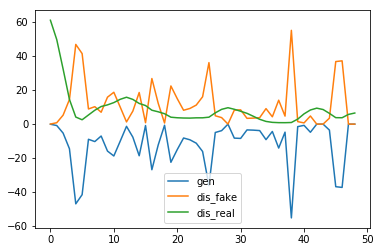

Generation 1  fitness : 8.0
#################################


/home/liam/Documents/GitHub/Evolution/helper.py:48: RuntimeWarning: invalid value encountered in true_divide
  pick_probabilities = normed/(np.sum(normed))
/home/liam/.local/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less


[ 8.  8. 26. 11.]
26.0
9.019755705231027
tensor([ 7.7805,  5.7860, 24.1620,  8.1079],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


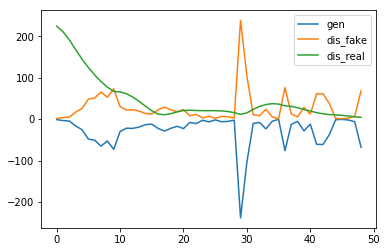

Generation 2  fitness : 26.0
#################################
[ 9. 18. 27. 10. 26. 17.]
27.0
8.880990896180418
tensor([10.0428, 10.3605, 23.8962,  4.4229, 11.9745, 11.1711],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


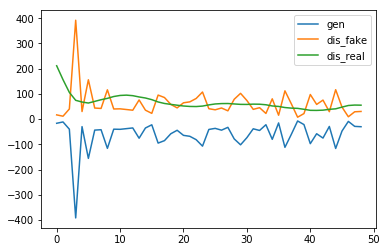

Generation 3  fitness : 27.0
#################################
[ 20.  16.  16.   8.  18.  13.  11. 126.]
73.0
12.223295679562314
tensor([ 17.1110,   4.9114,  17.5027,   6.1095,   8.3337,  10.8286,   0.2244,
        131.9503], device='cuda:0', grad_fn=<SqueezeBackward1>)


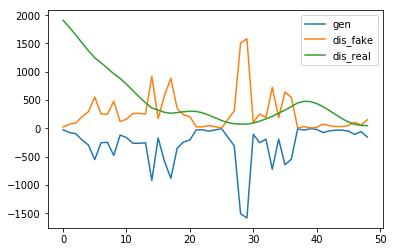

Generation 4  fitness : 126.0
#################################
[119.  95.  13.  64. 122.  11.  12.  13.]
120.5
12.694442607855422
tensor([84.0860, 85.0586,  6.2419, 47.1908, 85.1430,  5.4615,  7.4820,  8.6616],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


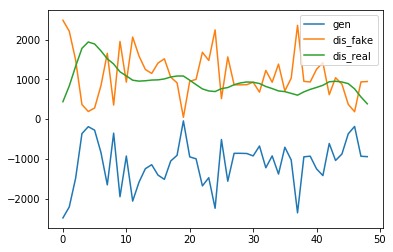

Generation 5  fitness : 122.0
#################################
[ 42.  77. 144.  74. 210. 130.  86.  90.]
177.0
12.796154380610886
tensor([20.3324, 54.4255, 68.6924, 55.1716, 81.7695, 66.8383, 46.1850, 46.1894],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


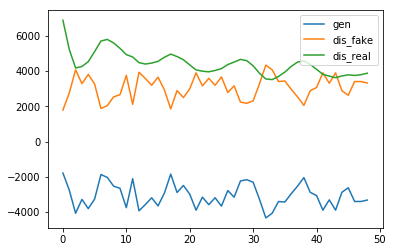

Generation 6  fitness : 210.0
#################################
[ 68. 172. 102.  99. 121.  76.  99.  70.]
146.5
11.923244080784373
tensor([37.7539, 72.9822, 40.3773, 49.7759, 57.2737, 49.6336, 53.3242, 34.3215],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


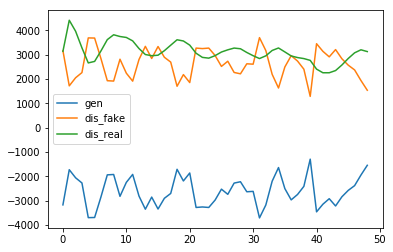

Generation 7  fitness : 172.0
#################################
[202. 165.  82.  89. 154. 119. 109. 127.]
183.5
12.273688792284993
tensor([82.9865, 79.3224, 71.3581, 58.3277, 77.8514, 59.7476, 60.5609, 62.9817],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


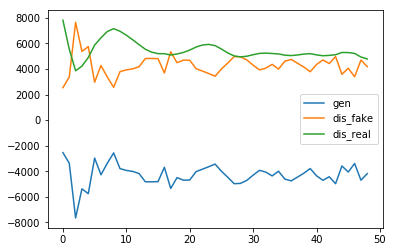

Generation 8  fitness : 202.0
#################################
[ 86.  86. 126.  96. 174.  93. 110. 108.]
150.0
11.618885000893545
tensor([49.1223, 50.3398, 71.4572, 51.8267, 82.3312, 71.9585, 51.7284, 59.3639],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


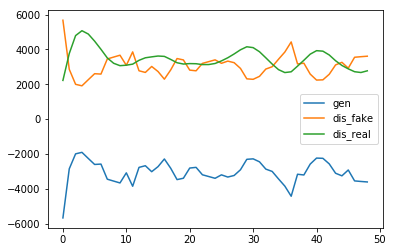

Generation 9  fitness : 174.0
#################################
[112. 126. 113. 121. 136. 180. 128.  91.]
158.0
11.361922967240169
tensor([60.3674, 62.6142, 60.0247, 70.5837, 70.5473, 76.6150, 61.5269, 53.1558],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


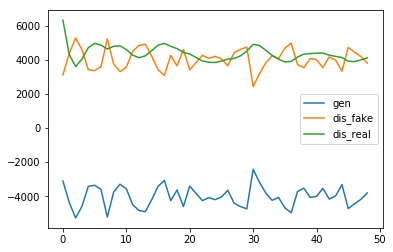

Generation 10  fitness : 180.0
#################################
[142. 280. 104.  86. 110. 207.  69. 122.]
243.5
13.371299991235833
tensor([ 40.6912, 127.9236,  44.3710,  32.0898,  49.5829,  77.5458,  28.9899,
         42.5813], device='cuda:0', grad_fn=<SqueezeBackward1>)


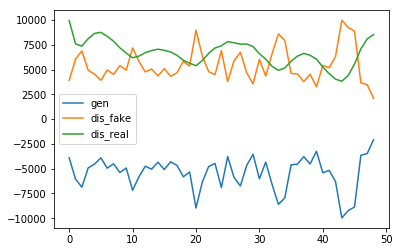

Generation 11  fitness : 280.0
#################################
[116. 119. 100.  85. 255. 111. 128.  89.]
191.5
12.860468341031861
tensor([ 60.7401,  57.7866,  58.8177,  59.8340, 114.9768,  81.1870,  64.5613,
         46.5919], device='cuda:0', grad_fn=<SqueezeBackward1>)


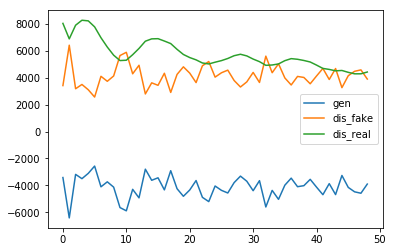

Generation 12  fitness : 255.0
#################################
[115. 261. 219. 223. 133. 130. 107. 127.]
242.0
13.049182574800765
tensor([ 63.8009, 130.7162,  93.8577, 123.5085,  88.2767,  97.3073,  51.0511,
         68.6400], device='cuda:0', grad_fn=<SqueezeBackward1>)


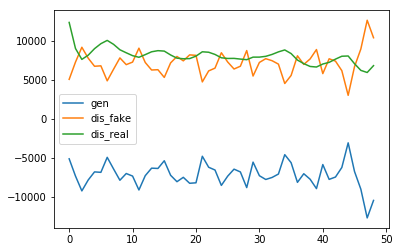

Generation 13  fitness : 261.0
#################################
[125. 102. 135. 148. 129. 164. 122. 120.]
156.0
10.734907606197591
tensor([69.1613, 62.0126, 81.3352, 65.2195, 52.6990, 75.7826, 60.9486, 50.9410],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


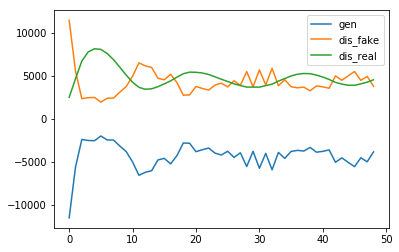

Generation 14  fitness : 164.0
#################################
[140.  96. 109. 193. 191. 129. 247. 153.]
220.0
12.699927322269877
tensor([ 80.1427,  51.6992,  68.5718,  81.8479,  91.3655,  85.4103, 104.7167,
         87.4097], device='cuda:0', grad_fn=<SqueezeBackward1>)


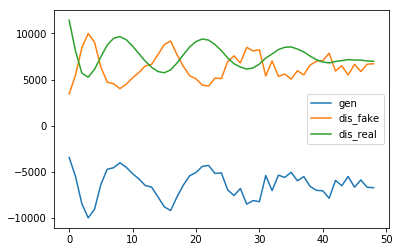

Generation 15  fitness : 247.0
#################################
[108. 119. 221. 133. 210. 155. 389. 187.]
305.0
13.875033705813731
tensor([ 89.1378,  64.5319,  80.6022,  78.8099, 109.8255,  69.2946, 195.8492,
        131.4660], device='cuda:0', grad_fn=<SqueezeBackward1>)


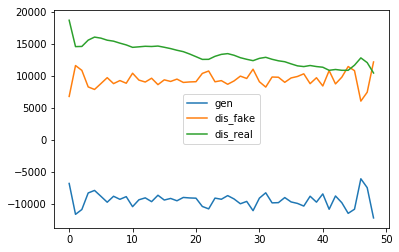

Generation 16  fitness : 389.0
#################################
[106.  88. 161. 145. 424.  96. 134. 115.]
292.5
14.268654974810856
tensor([ 55.5118,  92.4011,  75.7085,  53.9502, 112.7076,  81.4885,  68.7690,
         56.2880], device='cuda:0', grad_fn=<SqueezeBackward1>)


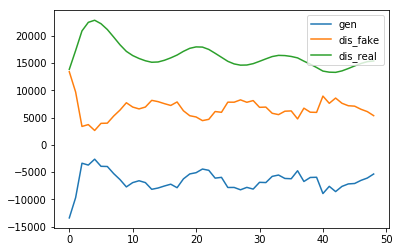

Generation 17  fitness : 424.0
#################################
[116. 198.  90. 152. 179. 131. 142. 138.]
188.5
11.921349951247908
tensor([65.4484, 84.5233, 54.7809, 75.5302, 85.0612, 72.5436, 79.8697, 73.4568],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


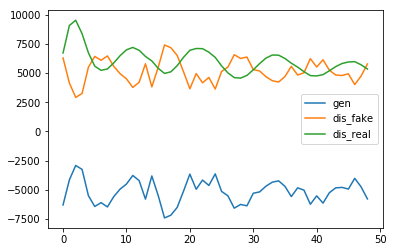

Generation 18  fitness : 198.0
#################################
[142. 171. 139. 139. 248. 141.  97. 120.]
209.5
12.477312557561923


In [ ]:
#randomly inititialise starting population
population_size = 2
max_population = 8    

batch_size = population_size
out_size = population_size
ranking = np.zeros([population_size])
parent_fitness = np.zeros([population_size])
population = []

for p in range(population_size):
    population.append(Creature().to(device))
    
old_population = population 

gen = Generator().to(device)
old_gen = gen
dis = Discriminator().to(device)

lr = 0.0001

print("starting training")
print(len(get_params(Creature())))
n_generations = 300


fit_bank = np.array([])
for i in range(n_generations):

    gen_optimizer = torch.optim.Adam(gen.parameters(), lr=lr,betas=(0.9,0.999))
    dis_optimizer = torch.optim.Adam(dis.parameters(), lr=lr,betas=(0.9,0.999))
    p_fitness, behavior_samples = measure_population_fitness(population,env,device,discrete_actions,
                                                             max_steps = 5000)
    
    
    
    
    #print(normed)
    if i == 0:
        old_fitness = p_fitness
    print(p_fitness)
    print(np.mean(np.sort(p_fitness)[p_fitness.size-p_fitness.size//4:]))
    
    #p_fitness = (p_fitness - np.min(np.concatenate([p_fitness,old_fitness])))/np.sqrt(np.var(p_fitness)+0.000001)
    #p_fitness =(p_fitness - np.min(p_fitness))/(np.max(p_fitness)-np.min(p_fitness))
    
    
    cat = np.concatenate([p_fitness,old_fitness])
    #min_fit = np.mean(np.sort(cat)[cat.size-cat.size//4:])
    min_fit = np.mean(np.sort(p_fitness)[p_fitness.size-p_fitness.size//4:])
    
    
    
    fit_bank = np.array(old_population)[np.where(old_fitness>min_fit)]
    fit_bank_fitness = np.array(old_fitness)[np.where(old_fitness>min_fit)]
    
    new_population = population
    new_population = np.concatenate((population,fit_bank))
    new_fitness = p_fitness
    new_fitness = np.concatenate((p_fitness,fit_bank_fitness))
    #new_batch_size = batch_size+fit_bank.size
    #new_batch_size = new_population.size
    new_batch_size = batch_size
    
    n_epochs = 50
    gen_loss, dis_loss,rec_loss = train_gan(population,p_fitness,
              batch_size =new_batch_size,n_epochs = n_epochs)
    
    plt.plot(gen_loss,label='gen')
    plt.plot(dis_loss,label='dis_fake')
    plt.plot(rec_loss,label='dis_real')
    #plt.ylim(-30, 30)
    plt.legend()
    plt.show()
    
    if i %10 == 0 and i != 0:
        fitness = measure_fitness(population[np.argmax(p_fitness)],env,device,discrete_actions,
                                  render = True,max_steps = 200)
    
    child_mutation_rate = 0.1
    mutation_scale = 0.07
    mutation_rate = np.ones(p_fitness.shape) * 0.1
    
    if np.mean(p_fitness) < 13:
        child_mutation_rate = 1
        mutation_rate = np.ones(p_fitness.shape)
        mutation_scale = 0.9
        child_mutation_rate = 1
        
    if out_size < max_population:
        out_size+=2
        batch_size = out_size
    
    old_population = population
    old_fitness = p_fitness
    population, parent_fitness = evolve(population,out_size,gen,old_gen,p_fitness,child_mutation_rate,
                                        mutation_rate,mutation_scale)
    old_gen = gen
    
    
    print("Generation {}  fitness : {}".format(i+1,np.max(p_fitness)))
    print("#################################")
